# Molecular Informatics: Chemical Property and Structure Retrieval

## 1. Introduction and Objectives
In this notebook, we explore the properties and structures of chemical compounds using data from the PubChem database. By entering the names of chemical compounds, users can retrieve:
- Molecular formula and weight
- Experimental data such as melting point, boiling point, density, and solubility
- Molecular structure visualizations

### Learning Objectives
1. Understand how to use APIs to retrieve chemical data.
2. Learn to parse and display chemical data in Python.
3. Visualize chemical structures using RDKit.

Let's start by loading the required libraries and defining functions to retrieve data from PubChem.


In [1]:
# Import Libraries
# Import necessary libraries for data retrieval and visualization
import requests  # To fetch data from PubChem API
from rdkit import Chem  # RDKit for handling chemical data
from rdkit.Chem import Draw  # RDKit for drawing chemical structures
from IPython.display import display  # To display images in the notebook
import pandas as pd  # To organize data in a table


In [2]:
# Function to retrieve the CID (PubChem Compound Identifier) for a given chemical name
def get_cid(chemical_name):
    """
    Fetches the CID (Compound Identifier) for a chemical name using the PubChem API.
    
    Parameters:
    - chemical_name (str): The name of the chemical compound.
    
    Returns:
    - int: CID of the compound if found, or None if not.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{chemical_name}/cids/JSON"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()["IdentifierList"]["CID"][0]
    except Exception as e:
        print(f"Error fetching CID for {chemical_name}: {e}")
        return None


Explanation of fetch_chemical_data Function

### Explanation of fetch_chemical_data Function

The fetch_chemical_data function in this notebook is designed to retrieve two types of data from the PubChem database for a given compound: 
1. **Basic Molecular Properties** (e.g., Molecular Formula, Molecular Weight, SMILES string)
2. **Experimental Properties** (e.g., Melting Point, Boiling Point, Density, Solubility)

These two categories require different API endpoints due to the nature of PubChem's data organization:

#### 1. Retrieving Basic Molecular Properties Using pug_rest

The pug_rest endpoint is a standard REST API used for retrieving basic chemical data quickly and efficiently. This endpoint provides properties such as the **Molecular Formula, Molecular Weight, and SMILES** string, which are straightforward values associated with each compound in PubChem’s database. We can fetch these basic properties with the following API structure:
```python
   prop_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/MolecularWeight,MolecularFormula,IsomericSMILES/JSON"




### 2. Why `pug_view` is Required for Experimental Properties

Experimental data (such as melting point, boiling point, density, and solubility) often involve detailed records with multiple data points, including conditions (e.g., temperature and pressure), source citations, and formatting for easy readability. Such data is stored in a more hierarchical and structured format, which `pug_rest` does not support.

To handle this, PubChem provides the `pug_view` endpoint, which allows access to the more complex records, including:

- **Hierarchical sections** (organized under "Chemical and Physical Properties" and "Experimental Properties").
- **Details on experimental conditions** and **source references** for each measurement.

Using the `pug_view` endpoint, we fetch experimental data as follows:

```python
exp_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{cid}/JSON"


In [3]:

# Function to fetch molecular properties and experimental data using CID
def fetch_chemical_data(cid):
    """
    Fetches molecular properties (formula, weight, SMILES) and experimental data
    (melting point, boiling point, density, solubility) for a given CID.
    
    Parameters:
    - cid (int): The PubChem Compound Identifier for the compound.
    
    Returns:
    - dict: Basic molecular properties such as Molecular Formula and Molecular Weight.
    - dict: Experimental properties such as Melting Point, Boiling Point, etc.
    """
    # Initialize data structures for properties and experimental data
    properties = {"MolecularWeight": "N/A", "MolecularFormula": "N/A", "IsomericSMILES": "N/A"}
    exp_data = {"Melting Point": [], "Boiling Point": [], "Density": [], "Solubility": []}

    # Fetch basic properties
    prop_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/MolecularWeight,MolecularFormula,IsomericSMILES/JSON"
    try:
        response = requests.get(prop_url)
        response.raise_for_status()
        properties.update(response.json()["PropertyTable"]["Properties"][0])
    except Exception as e:
        print(f"Error fetching properties for CID {cid}: {e}")

    # Fetch experimental data (e.g., melting point, boiling point, density)
    exp_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{cid}/JSON"
    try:
        response = requests.get(exp_url)
        response.raise_for_status()
        sections = response.json().get("Record", {}).get("Section", [])
        for section in sections:
            if section.get("TOCHeading") == "Chemical and Physical Properties":
                for sub_sec in section.get("Section", []):
                    if sub_sec.get("TOCHeading") == "Experimental Properties":
                        for prop in sub_sec.get("Section", []):
                            heading = prop.get("TOCHeading")
                            if heading in exp_data:
                                for info in prop.get("Information", []):
                                    for value in info.get("Value", {}).get("StringWithMarkup", []):
                                        exp_data[heading].append(value["String"])
    except Exception as e:
        print(f"Error fetching experimental data for CID {cid}: {e}")

    # Format experimental data as strings for easy display
    formatted_data = {key: ", ".join(values) or "N/A" for key, values in exp_data.items()}
    return properties, formatted_data


In [4]:
# Function to create an RDKit molecule object from a SMILES string for visualization
def fetch_structure(smiles):
    """
    Returns an RDKit molecule object for a given SMILES string, which
    can be used to generate a molecular structure image.
    
    Parameters:
    - smiles (str): SMILES representation of the chemical structure.
    
    Returns:
    - Mol: RDKit Mol object for the structure, or None if SMILES is invalid.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol if mol else None
    except Exception as e:
        print(f"Error generating structure for SMILES {smiles}: {e}")
        return None


## 3. Interactive Input Section
Enter the names of the compounds you'd like to analyze, separated by commas.


In [5]:
# Input for chemical names
chemical_names = input("Enter chemical names separated by commas: ").split(",")
chemical_names = [name.strip() for name in chemical_names if name.strip()]


In [6]:
# Data Retrieval and Display
data_rows = []

for chemical_name in chemical_names:
    cid = get_cid(chemical_name)
    if cid:
        properties, experimental_data = fetch_chemical_data(cid)
        
        # Add data to list for DataFrame
        data_rows.append({
            "Chemical Name": chemical_name,
            "Molecular Formula": properties.get("MolecularFormula", "N/A"),
            "Molecular Weight": f"{properties.get('MolecularWeight', 'N/A')} g/mol",
            "Melting Point": experimental_data["Melting Point"],
            "Boiling Point": experimental_data["Boiling Point"],
            "Density": experimental_data["Density"],
            "Solubility": experimental_data["Solubility"]
        })
    else:
        print(f"Error: CID not found for {chemical_name}")
        data_rows.append({
            "Chemical Name": chemical_name,
            "Molecular Formula": "Error",
            "Molecular Weight": "Error",
            "Melting Point": "Error",
            "Boiling Point": "Error",
            "Density": "Error",
            "Solubility": "Error"
        })

# Display results in DataFrame
df = pd.DataFrame(data_rows)
display(df)


,Chemical Name,Molecular Formula,Molecular Weight,Melting Point,Boiling Point,Density,Solubility
0,aspirin,C9H8O4,180.16 g/mol,"275 °F (NTP, 1992), 138-140, 135 °C (rapid hea...","284 °F at 760 mmHg (decomposes) (NTP, 1992), 2...","1.4 (NTP, 1992) - Denser than water; will sink...","less than 1 mg/mL at 73 °F (NTP, 1992), 1 g so..."



## Changing Data Formatting To Display All Data



In [7]:
df = pd.DataFrame(data_rows)
# Set display options to show all rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)  # Allow long text to wrap
pd.set_option("display.width", 1000)  # Prevent wrapping of wide tables
pd.set_option("display.max_rows", None)  # Display all rows without truncation

# Display DataFrame using IPython display
display(df)

,Chemical Name,Molecular Formula,Molecular Weight,Melting Point,Boiling Point,Density,Solubility
0,aspirin,C9H8O4,180.16 g/mol,"275 °F (NTP, 1992), 138-140, 135 °C (rapid heating), 135 °C, 135 °C, 275 °F, 275 °F","284 °F at 760 mmHg (decomposes) (NTP, 1992), 284 °F (decomposes), 284 °F (Decomposes)","1.4 (NTP, 1992) - Denser than water; will sink, 1.40, 1.4 g/cm³, 1.35, 1.35","less than 1 mg/mL at 73 °F (NTP, 1992), 1 g sol in: 300 mL water at 25 °C, 100 mL water at 37 °C, 5 mL alcohol, 17 mL chloroform, 10-15 mL ether; less sol in anhydrous ether, In water, 4,600 mg/L at 25 °C, Solubility in water, g/100ml at 15 °C: 0.25 (poor), (77 °F): 0.3%"


## 5. Visualization of Molecular Structures
Below, the molecular structures for each compound are displayed based on their SMILES representation.


Structure of aspirin:


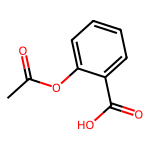

In [8]:
# Cell 12: Visualization of Molecular Structures
for chemical_name in chemical_names:
    cid = get_cid(chemical_name)
    if cid:
        properties, _ = fetch_chemical_data(cid)
        smiles = properties.get("IsomericSMILES", "")
        mol = fetch_structure(smiles)
        
        # Display the molecule image if available
        if mol:
            print(f"Structure of {chemical_name}:")
            display(Draw.MolToImage(mol, size=(150, 150)))
        else:
            print(f"No structure available for {chemical_name}")


## 6. Conclusion
This notebook demonstrated how to retrieve chemical information from PubChem, including molecular properties, experimental data, and molecular structure visualizations. This approach could be used for various applications in chemistry, bioinformatics, and drug discovery.


## 7. Future Goals
1. **Adding Hazards** : Need to find an API
2. **Adding Physical Properties** : Issue finding key words and parsing just gives paragraph

## TROUBLESHOOTING

#### with list seprarting at '.' and removing filler words such as 'and', 'in', 'of', etc.

In [9]:
import json
import requests
import re

def get_cid_from_name(compound_name):
    """Retrieve the CID of a compound from its name."""
    search_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{compound_name}/cids/JSON"
    response = requests.get(search_url)
    
    # Check if request was successful
    if response.status_code != 200:
        raise Exception("Failed to retrieve CID for the compound name.")
    
    data = response.json()
    try:
        return data["IdentifierList"]["CID"][0]  # Get the first CID found
    except (KeyError, IndexError):
        raise Exception("CID not found for the specified compound name.")

def get_descriptive_physical_properties(compound_name):
    """Retrieve descriptive physical properties of a compound given its name."""
    try:
        # Get CID for the compound name
        cid = get_cid_from_name(compound_name)
    except Exception as e:
        return str(e)
    
    # Construct the URL using the CID
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{cid}/JSON"
    
    # Request the compound's descriptive properties
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception("Failed to retrieve data.")
    
    data = response.json()
    descriptions = []
    
    try:
        # Accessing the primary sections
        sections = data["Record"]["Section"]
        for section in sections:
            if section["TOCHeading"] == "Names and Identifiers":
                for sub_section in section.get("Section", []):
                    if sub_section["TOCHeading"] == "Record Description":
                        for info in sub_section.get("Information", []):
                            descriptions.append(info["Value"]["StringWithMarkup"][0]["String"])
            elif section["TOCHeading"] == "Chemical and Physical Properties":
                for sub_section in section.get("Section", []):
                    if sub_section["TOCHeading"] == "Physical Description":
                        for info in sub_section.get("Information", []):
                            descriptions.append(info["Value"]["StringWithMarkup"][0]["String"])

        if not descriptions:
            return ["No descriptive properties found."]
        
        # Extract key descriptive words
        keywords = set()
        for description in descriptions:
            sentences = description.split('.')
            for sentence in sentences:
                words = re.findall(r'\b\w+\b', sentence)
                keywords.update(words)
        
        common_words = {"and", "the", "is", "of", "a", "with", "in", "to", "for", "as", "by"}
        key_terms = [word for word in keywords if word.lower() not in common_words]
        
        return key_terms if key_terms else ["No key descriptive terms found."]
    
    except KeyError as e:
        raise Exception(f"Key error while parsing JSON: {e}")

compound_name = "aspirin"
descriptive_properties = get_descriptive_physical_properties(compound_name)
print("Key Descriptive Terms:", descriptive_properties)


Key Descriptive Terms: ['ed', 'administered', 'children', 'active', 'Brassica', 'across', 'jaundice', 'Hoffmann', 'an', 'drug', 'ending', 'or', 'serine', 'plants', 'anti', 'German', 'something', 'assistant', 'antipyretic', 'genus', 'nature', 'problems', 'decrease', 'inflammation', 'kept', 'mechanism', 'it', 'when', '1897', 'reduced', 'ulmaria', 'stomach', 'replaced', 'Salicylic', 'synthetic', 'from', 'according', 'EC', 'cancers', 'arterial', 'hydroxyl', 'acetic', 'biosynthesis', 'drugs', 'derivatized', 'very', 'form', 'forms', 'female', 'hour', 'View', 'platelet', 'desire', 'Acetylsalicylic', 'pir', 'cyclooxygenase', 'fever', 'synthesis', 'reproductive', 'cause', 'prevention', 'Aloxiprin', 'only', 'Charles', 'independent', 'Decreased', 'plant', 'breast', 'byproduct', 'worked', 'resulting', 'committee', 'many', 'reflux', 'toxicity', 'class', 'lower', 'injury', 'toddlers', 'salicylate', 'Friedrich', 'naturally', 'several', 'Raffaele', 'others', '2', 'suppositories', 'should', 'able', 'cr

#### with addition of key words

In [10]:
import json
import requests
import re

def get_cid_from_name(compound_name):
    """Retrieve the CID of a compound from its name."""
    search_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{compound_name}/cids/JSON"
    response = requests.get(search_url)
    
    # Check if request was successful
    if response.status_code != 200:
        raise Exception("Failed to retrieve CID for the compound name.")
    
    data = response.json()
    try:
        return data["IdentifierList"]["CID"][0]  # Get the first CID found
    except (KeyError, IndexError):
        raise Exception("CID not found for the specified compound name.")

def get_descriptive_physical_properties(compound_name):
    """Retrieve physical properties (color, odor, state) of a compound given its name."""
    try:
        # Get CID for the compound name
        cid = get_cid_from_name(compound_name)
    except Exception as e:
        return str(e)
    
    # Construct the URL using the CID
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{cid}/JSON"
    
    # Request the compound's descriptive properties
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception("Failed to retrieve data.")
    
    data = response.json()
    descriptions = []
    
    try:
        # Accessing the primary sections
        sections = data["Record"]["Section"]
        for section in sections:
            # Focus only on "Chemical and Physical Properties"
            if section["TOCHeading"] == "Chemical and Physical Properties":
                for sub_section in section.get("Section", []):
                    # Look for "Physical Description" sub-section
                    if sub_section["TOCHeading"] == "Physical Description":
                        for info in sub_section.get("Information", []):
                            descriptions.append(info["Value"]["StringWithMarkup"][0]["String"])

        if not descriptions:
            return ["No descriptive physical properties found."]
        
        # Identify sentences containing physical property keywords
        physical_keywords = {"color","Color" "appearance","Appearance", "odor", "Odor", "state",  "State", "solid", "Solid", "liquid","Liquid", "gas", "Gas","crystalline", "Crystalline", "powder","Powder" }
        filtered_descriptions = []

        for description in descriptions:
            # Split by sentence and keep sentences with physical keywords
            sentences = description.split('.')
            for sentence in sentences:
                if any(keyword in sentence.lower() for keyword in physical_keywords):
                    filtered_descriptions.append(sentence.strip())

        # Remove duplicates and return the final list
        return list(set(filtered_descriptions)) if filtered_descriptions else ["No physical property descriptions found."]
    
    except KeyError as e:
        raise Exception(f"Key error while parsing JSON: {e}")

compound_name = "aspirin"
descriptive_properties = get_descriptive_physical_properties(compound_name)
print("Key Descriptive Physical Properties:", descriptive_properties)


Key Descriptive Physical Properties: ['No descriptive physical properties found.']
